<a href="https://colab.research.google.com/github/Twenkid/Colab-Notebooks-AI-ML-CV/blob/main/Phi_3_V_3_8B_Inference_Example_doesnt_work-24-5-2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLaVA++: Extending Visual Capabilities with LLaMA-3 and Phi-3
The project enhances the capabilities of the LLaVA-v1.5 model, incorporating latest LLMs including [Phi-3 Mini Instruct 3.8B](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct), and [LLaMA-3 Instruct 8B](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct).

In [ ]:
#Doesn't work #24-5-2024

## Phi-3-V-3.8B Inference Example

### Prepare the code

In [1]:
! git clone https://github.com/mbzuai-oryx/LLaVA-pp.git
%cd LLaVA-pp
! git submodule update --init --recursive

Cloning into 'LLaVA-pp'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 71 (delta 31), reused 60 (delta 20), pack-reused 0
Receiving objects: 100% (71/71), 6.47 MiB | 12.38 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/LLaVA-pp
Submodule 'LLaVA' (https://github.com/haotian-liu/LLaVA) registered for path 'LLaVA'
Cloning into '/content/LLaVA-pp/LLaVA'...
Submodule path 'LLaVA': checked out '3e337ad269da3245643a2724a1d694b5839c37f9'


### Copy the Phi-3-V files

In [ ]:
! cp Phi-3-V/train.py LLaVA/llava/train/train.py
! cp Phi-3-V/llava_phi3.py LLaVA/llava/model/language_model/llava_phi3.py
! cp Phi-3-V/builder.py LLaVA/llava/model/builder.py
! cp Phi-3-V/model__init__.py LLaVA/llava/model/__init__.py
! cp Phi-3-V/main__init__.py LLaVA/llava/__init__.py
! cp Phi-3-V/conversation.py LLaVA/llava/conversation.py

### Install dependencies

In [2]:
%cd LLaVA
! pip install --upgrade pip
! pip install -e .
! pip install git+https://github.com/huggingface/transformers@a98c41798cf6ed99e1ff17e3792d6e06a2ff2ff3

! export PYTHONPATH="./:$PYTHONPATH"

/content/LLaVA-pp/LLaVA
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Obtaining file:///content/LLaVA-pp/LLaVA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.7/137.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of typer[all] to determine which version is compatible with other requirements. This could tak

### Download the Phi-3-V pretrained checkpoints

In [3]:
! git lfs install
! git clone https://huggingface.co/MBZUAI/LLaVA-Phi-3-mini-4k-instruct

Updated git hooks.
Git LFS initialized.
Cloning into 'LLaVA-Phi-3-mini-4k-instruct'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 7), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (27/27), 11.17 KiB | 1.40 MiB/s, done.
Filtering content: 100% (3/3), 3.70 GiB | 16.48 MiB/s, done.
Encountered 1 file(s) that may not have been copied correctly on Windows:
	model-00001-of-00002.safetensors

See: `git lfs help smudge` for more details.


### Import the required packages

In [4]:
import torch
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IMAGE_PLACEHOLDER
from llava.conversation import conv_templates
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path
import requests
from PIL import Image
from io import BytesIO
import re
from llava.utils import disable_torch_init

### Define helper functions

In [5]:
def image_parser(args):
    out = args.image_file.split(args.sep)
    return out


def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


def load_images(image_files):
    out = []
    for image_file in image_files:
        image = load_image(image_file)
        out.append(image)
    return out

### Load the Model

In [6]:
disable_torch_init()

model_path = "LLaVA-Phi-3-mini-4k-instruct"
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, None, model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type llava_phi to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlavaLlamaForCausalLM were not initialized from the model checkpoint at LLaVA-Phi-3-mini-4k-instruct and are newly initialized: ['model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.1.mlp.gate_proj.weight', 'model.layers.1.mlp.up_proj.weight', 'model.layers.1.self_attn.k_proj.weight', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.v_proj.weight', 'model.layers.10.mlp.gate_proj.weight', 'model.layers.10.mlp.up_proj.weight', 'model.layers.10.self_attn.k_proj.weight', 'model.layers.10.self_attn.q_proj.weight', 'model.layers.10.self_attn.v_proj.weight', 'model.layers.11.mlp.gate_proj.weight', 'model.layers.11.mlp.up_proj.weight', 'model.layers.11.self_attn.k_proj.weight', 'model.layers.11.self_attn.q_proj.weight', 'model.layers.11.self_attn.v_proj.weight', 'model.layers.12.mlp.gate_proj.weight

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Create the prompt in Phi-3 Format

In [13]:
qs = "Describe the image in detail."
conv_mode = "llava_v1" #default" #phi3_instruct"
#dict_keys(['default', 'v0', 'v1', 'vicuna_v1', 'llama_2', 'mistral_instruct', 'chatml_direct', 'mistral_direct', 'plain', 'v0_plain', 'llava_v0', 'v0_mmtag', 'llava_v1', 'v1_mmtag', 'llava_llama_2', 'mpt'])
image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
if IMAGE_PLACEHOLDER in qs:
    if model.config.mm_use_im_start_end:
        qs = re.sub(IMAGE_PLACEHOLDER, image_token_se, qs)
    else:
        qs = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, qs)
else:
    if model.config.mm_use_im_start_end:
        qs = image_token_se + "\n" + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + "\n" + qs

conv = conv_templates[conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

print(prompt)

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Describe the image in detail. ASSISTANT:


In [8]:
print(conv_templates.keys())

dict_keys(['default', 'v0', 'v1', 'vicuna_v1', 'llama_2', 'mistral_instruct', 'chatml_direct', 'mistral_direct', 'plain', 'v0_plain', 'llava_v0', 'v0_mmtag', 'llava_v1', 'v1_mmtag', 'llava_llama_2', 'mpt'])


### Download and display the image

--2024-05-23 23:12:58--  http://images.cocodataset.org/val2017/000000281759.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.95.51, 3.5.6.101, 3.5.21.101, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.95.51|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187443 (183K) [image/jpeg]
Saving to: ‘000000281759.jpg.1’

000000281759.jpg.1  100%[===================>] 183.05K   962KB/s    in 0.2s    

2024-05-23 23:12:59 (962 KB/s) - ‘000000281759.jpg.1’ saved [187443/187443]



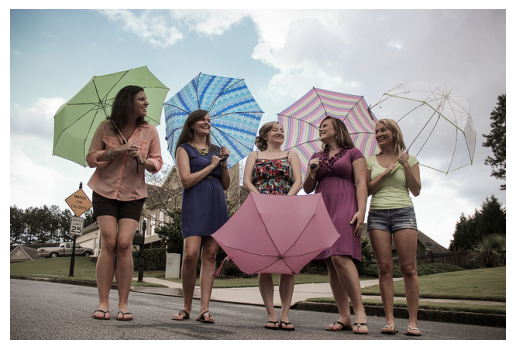

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

! wget http://images.cocodataset.org/val2017/000000281759.jpg

img = mpimg.imread('000000281759.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

### Prepare the inputs to Phi-3-V model

In [15]:
image_name = "000000281759.jpg"
image_files = [image_name]
images = load_images(image_files)
image_sizes = [x.size for x in images]
images_tensor = process_images(
    images,
    image_processor,
    model.config
).to(model.device, dtype=torch.float16)

input_ids = (
    tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
    .unsqueeze(0)
    .cuda()
)

### Generate and display the response

In [16]:
temperature = 0.2
top_p = 0.7
num_beams = 1
max_new_tokens = 512

with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=images_tensor,
        image_sizes=image_sizes,
        do_sample=True if temperature > 0 else False,
        temperature=temperature,
        top_p=top_p,
        num_beams=num_beams,
        max_new_tokens=max_new_tokens,
        use_cache=True,
    )

outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
outputs = outputs.replace("<|end|>", "").strip()
print(f"\n{outputs}\n")

TypeError: LlavaLlamaForCausalLM.forward() got an unexpected keyword argument 'cache_position'